# 11.7 Example: ZIP Code Data (WIP)

<img src="images/fig-11.10.png" alt="Networks" style="width: 560px;"/>

- Net-1: No hidden layer, equivalent to multinomial logistic regression.
- Net-2: One hidden layer, 12 hidden units fully connected.
- Net-3: Two hidden layers locally connected. (3x3 patch
- Net-4: Two hidden layers, locally connected with weight sharing.
- Net-5: Two hidden layers, locally connected, two levels of weight sharing.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def load_data(path):
    df = pd.read_csv(path, delim_whitespace=True, header=None)
    df_y = df.pop(0)
    return (tf.convert_to_tensor(df.values, dtype=tf.float32), 
            tf.convert_to_tensor(df_y.values, dtype=tf.int32))

train_x, train_y = load_data('../data/zipcode/zip.train')
test_x, test_y = load_data('../data/zipcode/zip.test')
epochs = 60

In [6]:
from abc import ABC, abstractmethod

class BaseModel(ABC, tf.keras.Model):
    def __init__(self):
        super(BaseModel, self).__init__()
       
    @abstractmethod
    def call(self, x):
        pass

    def loss(self, x, y):
        preds = self(x)
        return tf.keras.losses.sparse_categorical_crossentropy(y, preds, from_logits=True)

    def grad(self, x, y):
        with tf.GradientTape() as tape:
            loss_value = self.loss(x, y)
        return tape.gradient(loss_value, self.variables)
    
    def accuracy(self, dataset):
        accuracy = tf.metrics.Accuracy()
        for (x, y) in dataset:
            preds = tf.argmax(self(x), axis=1, output_type=tf.int32)
            accuracy(preds, y)
        return accuracy.result()
       
    def fit(self, x, y, test_x, test_y, epochs = 60, batch_size = 128):
        dataset = tf.data.Dataset.from_tensor_slices((x, y)) \
                                 .shuffle(buffer_size=1000) \
                                 .batch(batch_size)
        test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(batch_size)
        
        train_hist = []
        test_hist = []

        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        for i in range(epochs):
            for (x, y) in dataset:
                grads = self.grad(x, y)
                optimizer.apply_gradients(zip(grads, self.variables))
            train_hist.append(self.accuracy(dataset))
            test_hist.append(self.accuracy(test_dataset))

        return np.array(train_hist), np.array(test_hist)

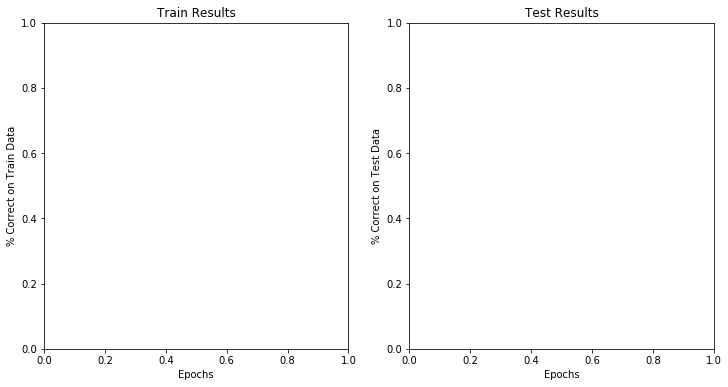

In [7]:
# Set up plotting
fig = plt.figure(figsize = (12, 6))
train_axes = fig.add_subplot(1, 2, 1)
train_axes.set_title('Train Results')
train_axes.set_xlabel('Epochs')
train_axes.set_ylabel('% Correct on Train Data')

test_axes = fig.add_subplot(1, 2, 2)
test_axes.set_title('Test Results')
test_axes.set_xlabel('Epochs')
test_axes.set_ylabel('% Correct on Test Data')

def plot_model(model, label, conv=False):
    shape = [-1, 16, 16, 1] if conv else [-1, 16*16]
    shaped_train_x = tf.reshape(train_x, shape)
    shaped_test_x = tf.reshape(test_x, shape)
    print(shaped_train_x.shape)
    print(shaped_test_x.shape)
    epochs_hist = np.arange(1, epochs + 1)
    train_hist, test_hist = model.fit(shaped_train_x, train_y, 
                                      test_x=shaped_test_x, test_y=test_y, 
                                      epochs=epochs)
    train_axes.plot(epochs_hist, train_hist * 100, label=label)
    train_axes.legend()
    test_axes.plot(epochs_hist, test_hist * 100, label=label)
    test_axes.legend()

(7291, 256)
(2007, 256)


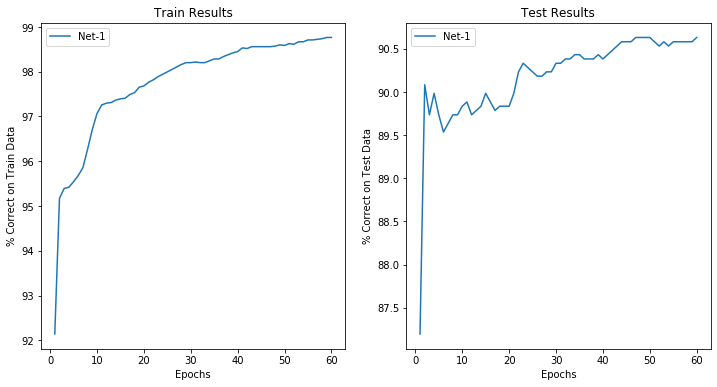

In [8]:
class Net1(BaseModel):
    def __init__(self):
        super(Net1, self).__init__()
        self.layer = tf.keras.layers.Dense(units=10)
    
    def call(self, x):
        return self.layer(x)

plot_model(Net1(), 'Net-1')
fig

(7291, 256)
(2007, 256)


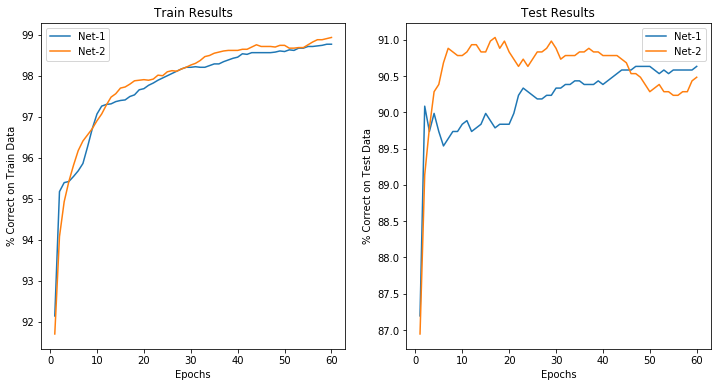

In [9]:
class Net2(BaseModel):
    def __init__(self):
        super(Net2, self).__init__()
        self.layer1 = tf.keras.layers.Dense(units=12, activation=tf.sigmoid)
        self.layer2 = tf.keras.layers.Dense(units=10)

    def call(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

plot_model(Net2(), 'Net-2')
fig

(7291, 16, 16, 1)
(2007, 16, 16, 1)


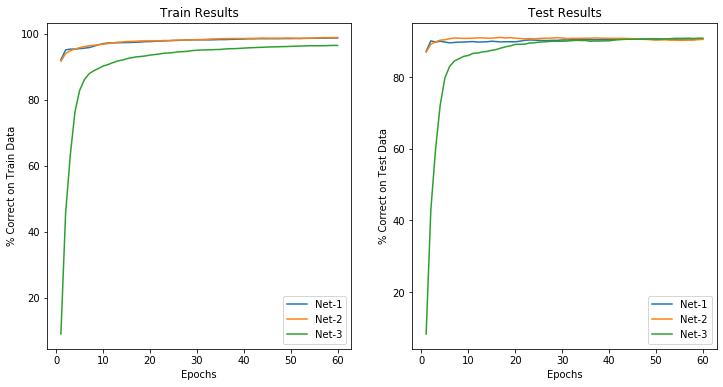

In [10]:
class Net3(BaseModel):
    def __init__(self):
        super(Net3, self).__init__()
        self.layer1 = tf.keras.layers.LocallyConnected2D(1, 2, strides=2, activation='sigmoid')
        self.layer2 = tf.keras.layers.LocallyConnected2D(1, 5, activation='sigmoid')
        self.layer3 = tf.keras.layers.Flatten()
        self.layer4 = tf.keras.layers.Dense(units=10)


    def call(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

plot_model(Net3(), 'Net-3', conv=True)
fig

(7291, 16, 16, 1)
(2007, 16, 16, 1)


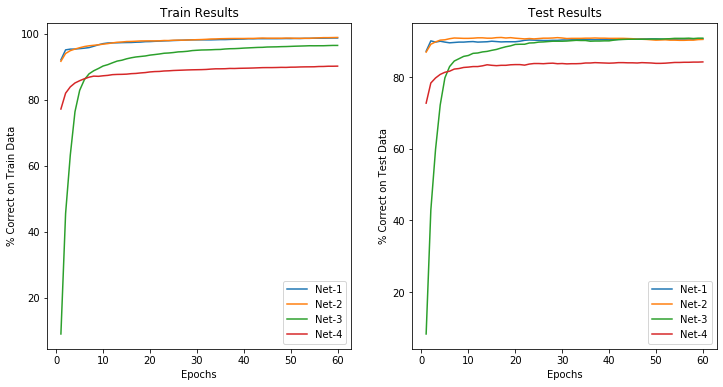

In [11]:
class Net4(BaseModel):
    def __init__(self):
        super(Net4, self).__init__()
        self.layer1 = tf.keras.layers.Conv2D(2, 2, strides=2, activation='sigmoid')
        self.layer2 = tf.keras.layers.Conv2D(1, 5, activation='sigmoid')
        self.layer3 = tf.keras.layers.Flatten()
        self.layer4 = tf.keras.layers.Dense(units=10)


    def call(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

plot_model(Net4(), 'Net-4', conv=True)
fig

(7291, 16, 16, 1)
(2007, 16, 16, 1)


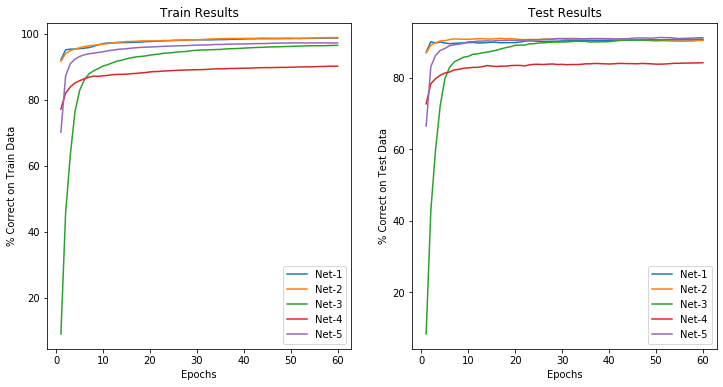

In [12]:
class Net5(BaseModel):
    def __init__(self):
        super(Net5, self).__init__()
        self.layer1 = tf.keras.layers.Conv2D(2, 2, strides=2, activation='sigmoid')
        self.layer2 = tf.keras.layers.Conv2D(4, 5, activation='sigmoid')
        self.layer3 = tf.keras.layers.Flatten()
        self.layer4 = tf.keras.layers.Dense(units=10)


    def call(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

plot_model(Net5(), 'Net-5', conv=True)
fig